# Data Imputation

In [1]:
%pip install scikit-learn

%pip install missforest

%pip install lightgbm


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 505.3 kB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### percentuale pazienti (solo peso, solo altezza, entrambi e nessuno)

In [3]:
import pandas as pd

try:
    df = pd.read_csv('db_scp_expanded.csv')
    
    # 1. Calcola il totale pazienti
    total_pazienti = len(df)
    
    if total_pazienti == 0:
        print("Il DataFrame è vuoto. Impossibile eseguire l'analisi.")
    else:
        # 2. Esegui i conteggi per i vari casi
        
        # --- CASO 1: Manca solo 'weight' ---
        solo_peso_mancante_df = df[df['weight'].isnull() & df['height'].notnull()]
        count_solo_peso = len(solo_peso_mancante_df)
        
        # --- CASO 2: Manca solo 'height' ---
        solo_altezza_mancante_df = df[df['height'].isnull() & df['weight'].notnull()]
        count_solo_altezza = len(solo_altezza_mancante_df)
        
        # --- CASO 3: Mancano entrambi ---
        entrambi_mancanti_df = df[df['weight'].isnull() & df['height'].isnull()]
        count_entrambi_mancanti = len(entrambi_mancanti_df) # Nome corretto
        
        # --- CASO 4: Completi (non mancano nessuno dei due) ---
        completi_df = df[df['weight'].notnull() & df['height'].notnull()]
        count_completi = len(completi_df)

        # 3. Calcola le percentuali
        perc_completi = (count_completi / total_pazienti) * 100
        perc_entrambi_mancanti = (count_entrambi_mancanti / total_pazienti) * 100
        perc_solo_peso = (count_solo_peso / total_pazienti) * 100
        perc_solo_altezza = (count_solo_altezza / total_pazienti) * 100
        
        # 4. Stampa i risultati in modo chiaro
        print("--- Analisi di Completezza per 'weight' e 'height' ---\n")
        print(f"Totale pazienti nel dataset: {total_pazienti}\n")
        
        print(f"✅ Pazienti con sia peso che altezza: \t{count_completi} ({perc_completi:.2f}%)")
        print(f"❌ Pazienti senza né peso né altezza: \t{count_entrambi_mancanti} ({perc_entrambi_mancanti:.2f}%)")
        print(f"📏 Pazienti con solo l'altezza: \t\t{count_solo_altezza} ({perc_solo_altezza:.2f}%)")
        print(f"⚖️ Pazienti con solo il peso: \t\t{count_solo_peso} ({perc_solo_peso:.2f}%)")
        
        print("\n" + "-"*55)
        
        # Somma di verifica
        total_check = count_completi + count_entrambi_mancanti + count_solo_peso + count_solo_altezza
        total_perc = perc_completi + perc_entrambi_mancanti + perc_solo_peso + perc_solo_altezza
        
        print(f"Verifica Conteggio: {count_completi} + {count_entrambi_mancanti} + {count_solo_peso} + {count_solo_altezza} = {total_check}")
        print(f"Verifica Percentuale: La somma è {total_perc:.2f}%")
        
        if total_check != total_pazienti:
            print(f"⚠️ ATTENZIONE: La somma dei conteggi ({total_check}) non corrisponde al totale pazienti ({total_pazienti}).")

except ImportError:
    print("❌ ERRORE: La libreria 'pandas' non è installata. Esegui `pip install pandas`.")
except FileNotFoundError:
    print(f"❌ ERRORE: File 'db_scp_expanded.csv' non trovato. Controlla il percorso del file.")
except KeyError as e:
    print(f"❌ ERRORE: La colonna {e} non è stata trovata nel DataFrame.")
    print("Controlla che i nomi 'weight' e 'height' siano scritti correttamente.")
except NameError as e:
    if 'pd' in str(e):
        print("❌ ERRORE: Il modulo 'pandas' non è stato importato correttamente (es. `import pandas as pd`).")
    elif 'df' in str(e):
         print("❌ ERRORE: Il DataFrame 'df' non è stato definito. Assicurati di aver caricato il tuo file.")
    else:
        print(f"❌ ERRORE DI PROGRAMMAZIONE: Variabile non definita: {e}")
except Exception as e:
    print(f"❌ ERRORE INASPETTATO: {e}")

--- Analisi di Completezza per 'weight' e 'height' ---

Totale pazienti nel dataset: 18869

✅ Pazienti con sia peso che altezza: 	6411 (33.98%)
❌ Pazienti senza né peso né altezza: 	9823 (52.06%)
📏 Pazienti con solo l'altezza: 		2419 (12.82%)
⚖️ Pazienti con solo il peso: 		216 (1.14%)

-------------------------------------------------------
Verifica Conteggio: 6411 + 9823 + 216 + 2419 = 18869
Verifica Percentuale: La somma è 100.00%


# Creo 3 nuovi db oltre l'originale

In [4]:
try:
    # --- 1. Caricamento del Dataset Originale ---
    df_originale = pd.read_csv('db_scp_expanded.csv')
    print(f"✅ Dataset 'db_final.csv' caricato con successo. Contiene {len(df_originale)} righe.")
    print("-" * 60)

    # --- 2. Creazione dei Nuovi DataFrame in Memoria ---
    df_completi = df_originale[df_originale['weight'].notnull() & df_originale['height'].notnull()].copy()
    df_solo_peso = df_originale[df_originale['weight'].notnull() & df_originale['height'].isnull()].copy()
    df_solo_altezza = df_originale[df_originale['weight'].isnull() & df_originale['height'].notnull()].copy()
    df_entrambi_mancanti = df_originale[df_originale['weight'].isnull() & df_originale['height'].isnull()].copy()
    
    print(f"📄 Creato 'df_completi' con {len(df_completi)} righe.")
    print(f"⚖️  Creato 'df_solo_peso' con {len(df_solo_peso)} righe.")
    print(f"📏 Creato 'df_solo_altezza' con {len(df_solo_altezza)} righe.")
    print(f"❌ Creato 'df_entrambi_mancanti' con {len(df_entrambi_mancanti)} righe.")
    print("-" * 60)

    # --- 3. Verifica di Coerenza (questo passaggio non cambia) ---
    somma_righe = len(df_completi) + len(df_solo_peso) + len(df_solo_altezza) + len(df_entrambi_mancanti)
    if somma_righe == len(df_originale):
        print("🎉 La segmentazione in memoria è corretta!")
    else:
        print("⚠️ Attenzione: C'è una discrepanza nel conteggio delle righe.")
    print("-" * 60)



except FileNotFoundError:
    print("❌ ERRORE: File 'db_final.csv' non trovato.")
except KeyError as e:
    print(f"❌ ERRORE: La colonna {e} non è stata trovata.")

✅ Dataset 'db_final.csv' caricato con successo. Contiene 18869 righe.
------------------------------------------------------------
📄 Creato 'df_completi' con 6411 righe.
⚖️  Creato 'df_solo_peso' con 2419 righe.
📏 Creato 'df_solo_altezza' con 216 righe.
❌ Creato 'df_entrambi_mancanti' con 9823 righe.
------------------------------------------------------------
🎉 La segmentazione in memoria è corretta!
------------------------------------------------------------


## Linear regression

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression # <-- Modello cambiato

# --- 1. Caricamento dati ---
try:
    df_originale = pd.read_csv('db_scp_expanded.csv')
except FileNotFoundError:
    print("ERRORE: File 'db_scp_expanded.csv' non trovato.")
    exit()
    
df_originale = df_originale.drop('scp_codes', axis=1, errors='ignore')

# --- 2. Suddivisione dei dataset ---
df_completi = df_originale[df_originale['weight'].notnull() & df_originale['height'].notnull()].copy()
df_solo_peso = df_originale[df_originale['weight'].notnull() & df_originale['height'].isnull()].copy()
df_solo_altezza = df_originale[df_originale['weight'].isnull() & df_originale['height'].notnull()].copy()
df_entrambi_mancanti = df_originale[df_originale['weight'].isnull() & df_originale['height'].isnull()].copy()

# --- 3. Aggiunta colonna "origine" per tracciabilità ---
df_completi["origine"] = "originale"
df_solo_peso["origine"] = "imputata_altezza"
df_solo_altezza["origine"] = "imputata_peso"
df_entrambi_mancanti["origine"] = "imputati_entrambi"

print(f"✅ Dati caricati:")
print(f"- Completi: {len(df_completi)}")
print(f"- Solo peso: {len(df_solo_peso)}")
print(f"- Solo altezza: {len(df_solo_altezza)}")
print(f"- Entrambi mancanti: {len(df_entrambi_mancanti)}")
print("-" * 60)

# --- 4. Identificazione colonne diagnostiche ---
# (Stessa logica della tua collega)
colonne_base = ['patient_id', 'age', 'sex', 'weight', 'height', 'origine']
colonne_diagnosi = [c for c in df_completi.columns if c not in colonne_base]
print(f"🧠 Colonne diagnostiche trovate: {len(colonne_diagnosi)}")
print(colonne_diagnosi[:10], "...")
print("-" * 60)


# === TASK A ===
# IMPUTARE HEIGHT (quando manca solo altezza)
print("📘 Task A: Addestramento modello [Linear Regression] per 'height'...")

features_height = ['age', 'sex', 'weight'] + colonne_diagnosi
target_height = 'height'

# Training
# Usiamo fillna(0) per replicare la logica della collega
X_train_h = df_completi[features_height].fillna(0)
y_train_h = df_completi[target_height]

model_height_lr = LinearRegression() # <-- Modello
model_height_lr.fit(X_train_h, y_train_h)

# Imputazione
X_impute_h = df_solo_peso[features_height].fillna(0)
df_solo_peso.loc[:, 'height'] = model_height_lr.predict(X_impute_h).round()

print("✅ Task A completato — altezza imputata.")
print("-" * 60)


# === TASK B ===
# IMPUTARE WEIGHT (quando manca solo peso)
print("📗 Task B: Addestramento modello [Linear Regression] per 'weight'...")

features_weight = ['age', 'sex', 'height'] + colonne_diagnosi
target_weight = 'weight'

# Training
X_train_w = df_completi[features_weight].fillna(0)
y_train_w = df_completi[target_weight]

model_weight_lr = LinearRegression() # <-- Modello
model_weight_lr.fit(X_train_w, y_train_w)

# Imputazione
X_impute_w = df_solo_altezza[features_weight].fillna(0)
df_solo_altezza.loc[:, 'weight'] = model_weight_lr.predict(X_impute_w).round()

print("✅ Task B completato — peso imputato.")
print("-" * 60)


# === TASK C ===
# IMPUTARE ENTRAMBI (peso + altezza mancanti)
print("📙 Task C: Addestramento [Linear Regression] per peso e altezza mancanti...")

features_both = ['age', 'sex'] + colonne_diagnosi

# Modello per HEIGHT
X_train_h2 = df_completi[features_both].fillna(0)
y_train_h2 = df_completi['height']
model_height_lr_both = LinearRegression() # <-- Modello
model_height_lr_both.fit(X_train_h2, y_train_h2)

# Modello per WEIGHT
X_train_w2 = df_completi[features_both].fillna(0)
y_train_w2 = df_completi['weight']
model_weight_lr_both = LinearRegression() # <-- Modello
model_weight_lr_both.fit(X_train_w2, y_train_w2)

# Imputazione effettiva
X_impute_both = df_entrambi_mancanti[features_both].fillna(0)
df_entrambi_mancanti.loc[:, 'height'] = model_height_lr_both.predict(X_impute_both).round()
df_entrambi_mancanti.loc[:, 'weight'] = model_weight_lr_both.predict(X_impute_both).round()

print("✅ Task C completato.")
print("-" * 60)


# --- 5. Merge finale ---
df_analisi_lr = pd.concat(
    [df_completi, df_solo_peso, df_solo_altezza, df_entrambi_mancanti],
    ignore_index=True
)

# Arrotondamento e tipo coerente
df_analisi_lr['weight'] = df_analisi_lr['weight'].round().astype(int)
df_analisi_lr['height'] = df_analisi_lr['height'].round().astype(int)

print("\n🎉 Dataset finale creato!")
print("Verifica nulli residui:")
print(df_analisi_lr[['weight', 'height']].isnull().sum())

# --- 6. Salvataggio ---
nome_file_output_lr = 'db_linear_regression.csv' # <-- Nuovo nome file
df_analisi_lr.to_csv(nome_file_output_lr, index=False)
print(f"\n💾 Dataset salvato come '{nome_file_output_lr}'!")

✅ Dati caricati:
- Completi: 6411
- Solo peso: 2419
- Solo altezza: 216
- Entrambi mancanti: 9823
------------------------------------------------------------
🧠 Colonne diagnostiche trovate: 71
['NORM', 'LVOLT', 'SR', 'SBRAD', 'IMI', 'ABQRS', 'SARRH', 'AFLT', 'AFIB', 'NDT'] ...
------------------------------------------------------------
📘 Task A: Addestramento modello [Linear Regression] per 'height'...
✅ Task A completato — altezza imputata.
------------------------------------------------------------
📗 Task B: Addestramento modello [Linear Regression] per 'weight'...
✅ Task B completato — peso imputato.
------------------------------------------------------------
📙 Task C: Addestramento [Linear Regression] per peso e altezza mancanti...
✅ Task C completato.
------------------------------------------------------------

🎉 Dataset finale creato!
Verifica nulli residui:
weight    0
height    0
dtype: int64

💾 Dataset salvato come 'db_linear_regression.csv'!


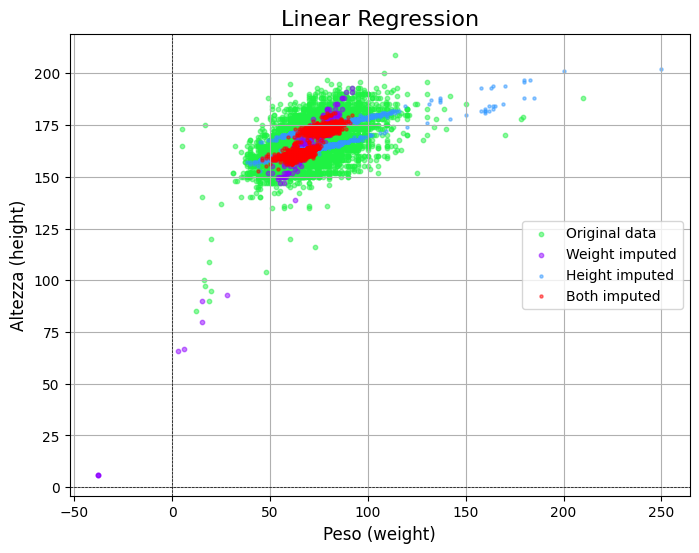

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Carichiamo il file creato dalla REGRESSIONE LINEARE
file_da_visualizzare = 'db_linear_regression.csv'

try:
    df = pd.read_csv(file_da_visualizzare)
except FileNotFoundError:
    print(f"ERRORE: File '{file_da_visualizzare}' non trovato.")
    print("Assicurati di aver eseguito prima lo script 'imputazione_linear.py'.")
    exit()

df_completi = df[df["origine"] == "originale"]
df_solo_peso = df[df["origine"] == "imputata_altezza"]
df_solo_altezza = df[df["origine"] == "imputata_peso"]
df_neither = df[df["origine"] == "imputati_entrambi"]

try:
    plt.figure(figsize=(8, 6))
    
    # 1. Grafico dei dati originali (erano già completi)
    plt.scatter(
        df_completi['weight'], 
        df_completi['height'], 
        c='#1ff243',           # Colori uguali alla collega
        label='Original data', 
        alpha=0.5, 
        s=10
    )
    
    # 2. Grafico dei dati dove abbiamo imputato il PESO
    plt.scatter(
        df_solo_altezza['weight'], 
        df_solo_altezza['height'], 
        c='#8f00ff', 
        label='Weight imputed', 
        alpha=0.5,
        s=10
    )
    
    # 3. Grafico dei dati dove abbiamo imputato l'ALTEZZA
    plt.scatter(
        df_solo_peso['weight'], 
        df_solo_peso['height'], 
        c='#3399ff', 
        label='Height imputed', 
        alpha=0.5,
        s=5
    )

    # 4. Grafico dei dati dove abbiamo imputato ENTRAMBI
    plt.scatter(
        df_neither['weight'], 
        df_neither['height'], 
        c='#FF0000', 
        label='Both imputed', 
        alpha=0.5,
        s=5
    )
    
    # --- Impostazioni del Grafico ---
    plt.title("Linear Regression", fontsize=16) # <-- Titolo Modificato
    plt.xlabel('Peso (weight)', fontsize=12)
    plt.ylabel('Altezza (height)', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    plt.show()

except Exception as e:
    print(f"Si è verificato un errore durante la creazione del grafico: {e}")

## KNN imputation

In [9]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

try:
    df_completi["origine"] = "originale"
    df_solo_peso["origine"] = "imputata_altezza"
    df_solo_altezza["origine"] = "imputata_peso"
    
    print(f"✅ Dati caricati: {len(df_completi)} completi, {len(df_solo_peso)} solo peso, {len(df_solo_altezza)} solo altezza.")
    print("-" * 60)

    # --- 2. Task A: Imputare l'Altezza (in 'df_solo_peso') ---
    
    print("Inizio Task A: Imputazione 'height' (Altezza)...")
    
    # Definiamo le feature (predittori) e il target
    features_height = ['age', 'sex', 'weight']
    target_height = 'height'
    
    # Prepariamo i dati di addestramento (dal db completo)
    X_train_h = df_completi[features_height]
    y_train_h = df_completi[target_height]
    
    # Prepariamo i dati su cui imputare (dal db solo_peso)
    X_impute_h = df_solo_peso[features_height]
    
    # Creiamo e addestriamo il modello KNN
    # n_neighbors=5 significa che useremo i 5 "vicini" più simili per fare la media
    model_height_knn = KNeighborsRegressor(n_neighbors=7)
    model_height_knn.fit(X_train_h, y_train_h)
    
    # Eseguiamo la predizione (l'imputazione)
    predicted_heights = model_height_knn.predict(X_impute_h).round()
    
    # Assegniamo i valori predetti alla colonna 'height'
    df_solo_peso.loc[:, 'height'] = predicted_heights
    
    print("✅ Task A completato. Esempio 'df_solo_peso' imputato:")
    print(df_solo_peso[['sex', 'age', 'weight', 'height']].head())
    print("-" * 60)

    # --- 3. Task B: Imputare il Peso (in 'df_solo_altezza') ---
    
    print("Inizio Task B: Imputazione 'weight' (Peso)...")
    
    # Definiamo le feature e il target
    features_weight = ['age', 'sex', 'height']
    target_weight = 'weight'
    
    # Dati di addestramento
    X_train_w = df_completi[features_weight]
    y_train_w = df_completi[target_weight]
    
    # Dati da imputare
    X_impute_w = df_solo_altezza[features_weight]
    
    # Creiamo e addestriamo un NUOVO modello KNN
    model_weight_knn = KNeighborsRegressor(n_neighbors=7)
    model_weight_knn.fit(X_train_w, y_train_w)
    
    # Eseguiamo la predizione
    predicted_weights = model_weight_knn.predict(X_impute_w).round()
    
    # Assegniamo i valori
    df_solo_altezza.loc[:, 'weight'] = predicted_weights
    
    print("✅ Task B completato. Esempio 'df_solo_altezza' imputato:")
    print(df_solo_altezza[['sex', 'age', 'weight', 'height']].head())
    print("-" * 60)

    # --- 4. Creazione e Salvataggio del Dataset Finale ---
    
    # Uniamo i 3 DataFrame: i completi originali + i 2 che abbiamo appena "curato"
    df_analisi_knn = pd.concat([df_completi, df_solo_peso, df_solo_altezza], ignore_index=True)
    
    print("\n🎉 Dataset finale 'df_analisi_knn' creato unendo i 3 gruppi.")
    print(f"Dimensione totale: {len(df_analisi_knn)} righe.")
    
    # Verifica finale dei valori nulli
    print("\nVerifica valori nulli residui:")
    print(df_analisi_knn[['weight', 'height']].isnull().sum())

    df_analisi_knn['weight'] = df_analisi_knn['weight'].round().astype(int)
    df_analisi_knn['height'] = df_analisi_knn['height'].round().astype(int)

    
    # Salvataggio del nuovo file CSV
    nome_file_output_knn = 'db_knn.csv'
    df_analisi_knn.to_csv(nome_file_output_knn, index=False)
    
    print(f"\n💾 Dataset finale (e corretto) salvato come '{nome_file_output_knn}'!")


except FileNotFoundError as e:
    print(f"❌ ERRORE: File non trovato. Assicurati che '{e.filename}' sia nella stessa cartella.")
except KeyError as e:
    print(f"❌ ERRORE: Colonna {e} non trovata. Controlla i nomi delle colonne nei tuoi file CSV.")

✅ Dati caricati: 6411 completi, 2419 solo peso, 216 solo altezza.
------------------------------------------------------------
Inizio Task A: Imputazione 'height' (Altezza)...
✅ Task A completato. Esempio 'df_solo_peso' imputato:
   sex   age  weight  height
0    1  56.0    63.0   161.0
1    0  19.0    70.0   180.0
2    1  37.0    69.0   164.0
3    0  24.0    82.0   173.0
4    1  19.0    70.0   180.0
------------------------------------------------------------
Inizio Task B: Imputazione 'weight' (Peso)...
✅ Task B completato. Esempio 'df_solo_altezza' imputato:
     sex    age  weight  height
226    0   63.0    70.0   165.0
251    0  100.0    73.0   175.0
458    0   67.0    79.0   170.0
596    1   78.0    70.0   173.0
597    1   87.0    59.0   152.0
------------------------------------------------------------

🎉 Dataset finale 'df_analisi_knn' creato unendo i 3 gruppi.
Dimensione totale: 9046 righe.

Verifica valori nulli residui:
weight    0
height    0
dtype: int64

💾 Dataset finale 

## KNN - usando SCP_CODES (e imputo entrambi mancanti)

ORA IMPUTIAMO ANCHE DOVE MANCANO ENTRAMBI

In [138]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

# --- 1. Caricamento dati ---
df_originale = pd.read_csv('db_scp_expanded.csv')
df_originale = df_originale.drop('scp_codes', axis=1)

# --- 2. Suddivisione dei dataset ---
df_completi = df_originale[df_originale['weight'].notnull() & df_originale['height'].notnull()].copy()
df_solo_peso = df_originale[df_originale['weight'].notnull() & df_originale['height'].isnull()].copy()
df_solo_altezza = df_originale[df_originale['weight'].isnull() & df_originale['height'].notnull()].copy()
df_entrambi_mancanti = df_originale[df_originale['weight'].isnull() & df_originale['height'].isnull()].copy()

# --- 3. Aggiunta colonna "origine" per tracciabilità ---
df_completi["origine"] = "originale"
df_solo_peso["origine"] = "imputata_altezza"
df_solo_altezza["origine"] = "imputata_peso"
df_entrambi_mancanti["origine"] = "imputati_entrambi"

print(f"✅ Dati caricati:")
print(f"- Completi: {len(df_completi)}")
print(f"- Solo peso: {len(df_solo_peso)}")
print(f"- Solo altezza: {len(df_solo_altezza)}")
print(f"- Entrambi mancanti: {len(df_entrambi_mancanti)}")
print("-" * 60)

# --- 4. Identificazione colonne diagnostiche ---
colonne_base = ['age', 'sex', 'weight', 'height', 'origine']
colonne_diagnosi = [c for c in df_completi.columns if c not in colonne_base]
print(f"🧠 Colonne diagnostiche trovate: {len(colonne_diagnosi)}")
print(colonne_diagnosi[:10], "...")
print("-" * 60)


# === TASK A ===
# IMPUTARE HEIGHT (quando manca solo altezza)
print("📘 Task A: Addestramento modello per 'height' (usando peso + diagnosi)...")

features_height = ['age', 'sex', 'weight'] + colonne_diagnosi
target_height = 'height'

# Training
X_train_h = df_completi[features_height].fillna(0)
y_train_h = df_completi[target_height]

model_height_knn = KNeighborsRegressor(n_neighbors=7)
model_height_knn.fit(X_train_h, y_train_h)

# Imputazione
X_impute_h = df_solo_peso[features_height].fillna(0)
df_solo_peso.loc[:, 'height'] = model_height_knn.predict(X_impute_h).round()

print("✅ Task A completato — altezza imputata dove mancava.")
print(df_solo_peso[['sex', 'age', 'weight', 'height']].head())
print("-" * 60)


# === TASK B ===
# IMPUTARE WEIGHT (quando manca solo peso)
print("📗 Task B: Addestramento modello per 'weight' (usando altezza + diagnosi)...")

features_weight = ['age', 'sex', 'height'] + colonne_diagnosi
target_weight = 'weight'

# Training
X_train_w = df_completi[features_weight].fillna(0)
y_train_w = df_completi[target_weight]

model_weight_knn = KNeighborsRegressor(n_neighbors=7)
model_weight_knn.fit(X_train_w, y_train_w)

# Imputazione
X_impute_w = df_solo_altezza[features_weight].fillna(0)
df_solo_altezza.loc[:, 'weight'] = model_weight_knn.predict(X_impute_w).round()

print("✅ Task B completato — peso imputato dove mancava.")
print(df_solo_altezza[['sex', 'age', 'weight', 'height']].head())
print("-" * 60)


# === TASK C ===
# IMPUTARE ENTRAMBI (peso + altezza mancanti)
print("📙 Task C: Addestramento modello per 'weight' e 'height' dove mancano entrambi...")

# Per questo caso usiamo SOLO age, sex e diagnosi, poiché mancano entrambe le variabili
features_both = ['age', 'sex'] + colonne_diagnosi

# Modello per HEIGHT
X_train_h2 = df_completi[features_both].fillna(0)
y_train_h2 = df_completi['height']
model_height_knn_both = KNeighborsRegressor(n_neighbors=7)
model_height_knn_both.fit(X_train_h2, y_train_h2)

# Modello per WEIGHT
X_train_w2 = df_completi[features_both].fillna(0)
y_train_w2 = df_completi['weight']
model_weight_knn_both = KNeighborsRegressor(n_neighbors=7)
model_weight_knn_both.fit(X_train_w2, y_train_w2)

# Imputazione effettiva
X_impute_both = df_entrambi_mancanti[features_both].fillna(0)
df_entrambi_mancanti.loc[:, 'height'] = model_height_knn_both.predict(X_impute_both).round()
df_entrambi_mancanti.loc[:, 'weight'] = model_weight_knn_both.predict(X_impute_both).round()

print("✅ Task C completato — imputati peso e altezza mancanti.")
print(df_entrambi_mancanti[['sex', 'age', 'weight', 'height']].head())
print("-" * 60)


# --- 5. Merge finale ---
df_analisi_knn = pd.concat(
    [df_completi, df_solo_peso, df_solo_altezza, df_entrambi_mancanti],
    ignore_index=True
)

# Arrotondamento e tipo coerente
df_analisi_knn['weight'] = df_analisi_knn['weight'].round().astype(int)
df_analisi_knn['height'] = df_analisi_knn['height'].round().astype(int)

print("\n🎉 Dataset finale creato!")
print(df_analisi_knn[['weight', 'height']].isnull().sum())

# --- 6. Salvataggio ---
nome_file_output_knn = 'db_knn_con_diagnosi.csv'
df_analisi_knn.to_csv(nome_file_output_knn, index=False)
print(f"\n💾 Dataset salvato come '{nome_file_output_knn}'!")


✅ Dati caricati:
- Completi: 6411
- Solo peso: 2419
- Solo altezza: 216
- Entrambi mancanti: 9823
------------------------------------------------------------
🧠 Colonne diagnostiche trovate: 72
['patient_id', 'NORM', 'LVOLT', 'SR', 'SBRAD', 'IMI', 'ABQRS', 'SARRH', 'AFLT', 'AFIB'] ...
------------------------------------------------------------
📘 Task A: Addestramento modello per 'height' (usando peso + diagnosi)...
✅ Task A completato — altezza imputata dove mancava.
   sex   age  weight  height
0    1  56.0    63.0   171.0
1    0  19.0    70.0   172.0
2    1  37.0    69.0   172.0
3    0  24.0    82.0   173.0
4    1  19.0    70.0   169.0
------------------------------------------------------------
📗 Task B: Addestramento modello per 'weight' (usando altezza + diagnosi)...
✅ Task B completato — peso imputato dove mancava.
     sex    age  weight  height
226    0   63.0    67.0   165.0
251    0  100.0    71.0   175.0
458    0   67.0    69.0   170.0
596    1   78.0    79.0   173.0
597   

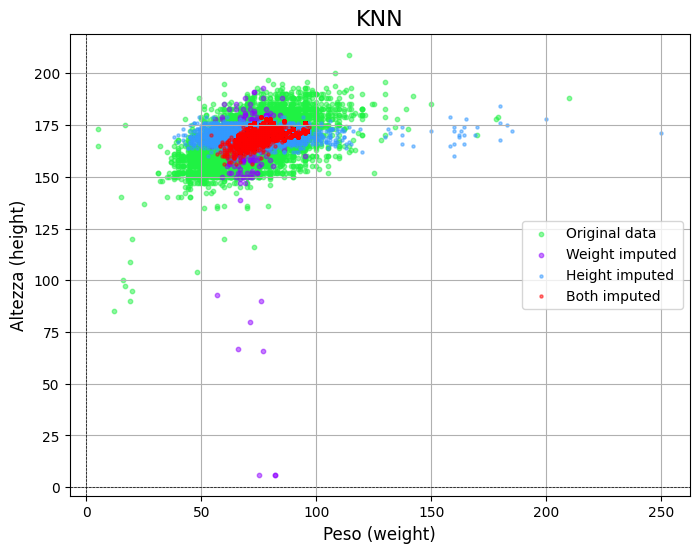

In [141]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('db_knn_con_diagnosi.csv')

df_completi = df[df["origine"] == "originale"]
df_solo_peso = df[df["origine"] == "imputata_altezza"]
df_solo_altezza = df[df["origine"] == "imputata_peso"]
df_neither = df[df["origine"] == "imputati_entrambi"]

try:
    plt.figure(figsize=(8, 6))
    
    # 1. Grafico dei dati originali (erano già completi)
    plt.scatter(
        df_completi['weight'], 
        df_completi['height'], 
        c='#1ff243',          # Colore blu
        label='Original data', 
        alpha=0.5,          # Trasparenza per vedere le sovrapposizioni
        s=10
    )
    
    # 2. Grafico dei dati dove abbiamo imputato il PESO (green)
    plt.scatter(
        df_solo_altezza['weight'], 
        df_solo_altezza['height'], 
        c='#8f00ff',         # Colore verde
        label='Weight imputed', 
        alpha=0.5,
        s=10
    )
    
    # 3. Grafico dei dati dove abbiamo imputato l'ALTEZZA (blue)
    plt.scatter(
        df_solo_peso['weight'], 
        df_solo_peso['height'], 
        c='#3399ff',          # Colore blue
        label='Height imputed', 
        alpha=0.5,
        s=5
    )

    # 4. Grafico dei dati dove abbiamo imputato ENTRAMBI (rosso)
    plt.scatter(
        df_neither['weight'], 
        df_neither['height'], 
        c='#FF0000',          # Colore rosso
        label='Both imputed', 
        alpha=0.5,
        s=5
    )
    
    # --- Impostazioni del Grafico ---
    plt.title("KNN", fontsize=16)
    plt.xlabel('Peso (weight)', fontsize=12)
    plt.ylabel('Altezza (height)', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # Aggiungiamo linee per lo zero per un confronto chiaro
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    plt.show()

except NameError:
    print("❌ ERRORE: DataFrame non trovato.")
    print("Assicurati di aver eseguito il codice di imputazione KNN prima di questa cella.")
except Exception as e:
    print(f"Si è verificato un errore: {e}")

## Miss Forest

In [11]:
import pandas as pd
import numpy as np
from missforest.missforest import MissForest
import lightgbm 

# --- 1. Caricamento Dati ---
file_name = 'db_scp_expanded.csv'
output_filename = 'db_missforest.csv'

try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    df = None
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    df = None

if df is not None:
    df_clean = df.copy()

    # --- Crea colonna 'origine' per tracciare i dati imputati ---
    condizione_completi = df_clean['height'].notnull() & df_clean['weight'].notnull()
    condizione_manca_altezza = df_clean['height'].isnull() & df_clean['weight'].notnull()
    condizione_manca_peso = df_clean['height'].notnull() & df_clean['weight'].isnull()

    df_clean['origine'] = np.select(
        [condizione_completi, condizione_manca_altezza, condizione_manca_peso],
        ['completi', 'manca_altezza', 'manca_peso'],
        default='manca_entrambi'
    )

    print("--- Dati Originali (prime 5 righe) ---")
    print(df_clean.head())
    print("\nValori nulli PRIMA di MissForest:")
    print(df_clean[['height', 'weight']].isnull().sum())

    # --- 2. Preparazione dati per MissForest ---
    print("\n--- 2. Preparazione dati per l'imputer ---")
    colonne_da_escludere = ['patient_id', 'scp_codes', 'origine']
    colonne_presenti = [col for col in colonne_da_escludere if col in df_clean.columns]
    df_to_impute = df_clean.drop(columns=colonne_presenti)

    print("Preparazione dati completata. 'patient_id' e 'origine' saranno ignorati da MissForest.")

    # --- 3. Imputazione (MissForest) ---
    print("\n--- 3. Avvio di MissForest... (potrebbe richiedere tempo) ---")
    imputer = MissForest(max_iter=5)
    data_imputed = imputer.fit_transform(df_to_impute)
    print("Imputazione completata.")

    # --- 4. Creazione DataFrame Temporaneo ---
    df_imputed_temp = pd.DataFrame(data_imputed, columns=df_to_impute.columns)

    print("\n--- 4. Pulizia Tipi di Dati (Arrotondamento) ---")
    df_imputed_temp['height'] = df_imputed_temp['height'].round(1)
    df_imputed_temp['weight'] = df_imputed_temp['weight'].round(1)

    # --- 5. Ricostruzione del DataFrame finale ---
    print("--- 5. Ricostruzione del DataFrame finale ---")
    df_final = df_clean.copy()
    df_final['height'] = df_imputed_temp['height']
    df_final['weight'] = df_imputed_temp['weight']

    # ✅ Manteniamo la colonna 'origine' per sapere dove è stata fatta l’imputazione
    # (era già in df_clean, quindi viene mantenuta automaticamente)

    # --- 6. Salvataggio su CSV ---
    try:
        df_final.to_csv(output_filename, index=False, float_format='%.1f')
        print("\n============================================")
        print(f"--- SALVATAGGIO COMPLETATO ---")
        print(f"Dati imputati salvati con successo in: {output_filename}")
        print("\n--- Prime 5 righe del nuovo file ---")
        print(df_final.head())
        print("\nValori nulli DOPO l'imputazione:")
        print(df_final[['height', 'weight']].isnull().sum())
        print("============================================")
    except Exception as e:
        print(f"\n--- 6. ERRORE NEL SALVATAGGIO ---")
        print(f"Si è verificato un errore durante il salvataggio: {e}")


/root/venv/lib/python3.10/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
File 'db_scp_expanded.csv' caricato con successo.
--- Dati Originali (prime 5 righe) ---
   patient_id  sex   age  height  weight  \
0     15709.0    1  56.0     NaN    63.0   
1     13243.0    0  19.0     NaN    70.0   
2     20372.0    1  37.0     NaN    69.0   
3     17014.0    0  24.0     NaN    82.0   
4     17448.0    1  19.0     NaN    70.0   

                                  scp_codes   NORM  LVOLT   SR  SBRAD  ...  \
0  {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}  100.0    0.0  0.0    0.0  ...   
1              {'NORM': 80.0, 'SBRAD': 0.0}   80.0    0.0  0.0    0.0  ...   
2                {'NORM': 100.0, 'SR': 0.0}  100.0    0.0  0.0    0.0  ...   
3                {'NORM': 100.0, 'SR': 0.0}  100.0    0.0  0

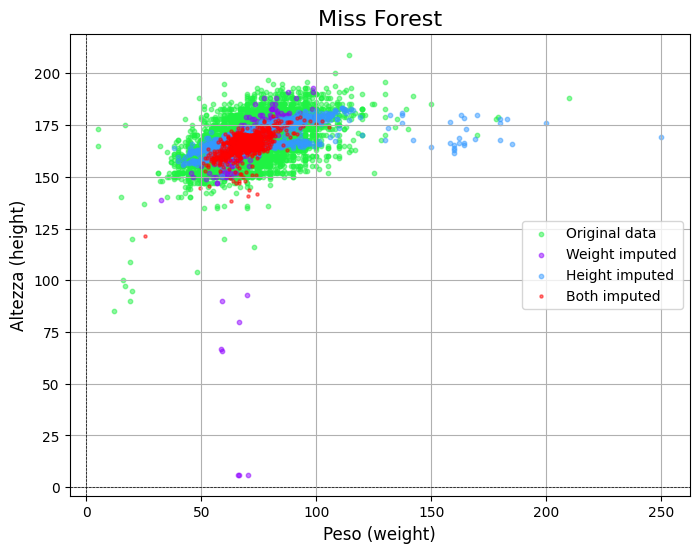

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('db_missforest.csv')

try:
    plt.figure(figsize=(8, 6))
    
    # 1. Grafico dei dati originali (erano già completi)
    df_completi = df[df['origine'] == 'completi']

    plt.scatter(
        df_completi['weight'], 
        df_completi['height'], 
        c='#1ff243',          # Colore verde
        label='Original data', 
        alpha=0.5,          # Trasparenza per vedere le sovrapposizioni
        s=10
    )
    
    # 2. Grafico dei dati dove abbiamo imputato il PESO (purple)
    df_solo_altezza = df[df['origine'] == 'manca_peso']
    plt.scatter(
        df_solo_altezza['weight'], 
        df_solo_altezza['height'], 
        c='#8f00ff',         # Colore purple
        label='Weight imputed', 
        alpha=0.5,
        s=10
    )
    
    # 3. Grafico dei dati dove abbiamo imputato l'ALTEZZA (blue)
    df_solo_peso = df[df['origine'] == 'manca_altezza']
    plt.scatter(
        df_solo_peso['weight'], 
        df_solo_peso['height'], 
        c='#3399ff',          # Colore blue
        label='Height imputed', 
        alpha=0.5,
        s=10
    )

    # 4. Grafico dei dati dove abbiamo imputato entrambi (red)
    df_manca_entrambi = df[df['origine'] == 'manca_entrambi']
    plt.scatter(
        df_manca_entrambi['weight'], 
        df_manca_entrambi['height'], 
        c='#ff0000',         # Colore rosso
        label='Both imputed', 
        alpha=0.5,
        s=5
    )
    
    # --- Impostazioni del Grafico ---
    plt.title("Miss Forest", fontsize=16)
    plt.xlabel('Peso (weight)', fontsize=12)
    plt.ylabel('Altezza (height)', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # Aggiungiamo linee per lo zero per un confronto chiaro
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    plt.show()

except NameError:
    print("❌ ERRORE: DataFrame non trovato.")
    print("Assicurati di aver eseguito il codice di imputazione KNN prima di questa cella.")
except Exception as e:
    print(f"Si è verificato un errore: {e}")

- confronto dopo l'imputazione (altezza)

File 'db_missforest.csv' caricato con successo.
Dati filtrati pronti per il plot. Categorie trovate: ['completi', 'manca_altezza']
Visualizzazione grafico...


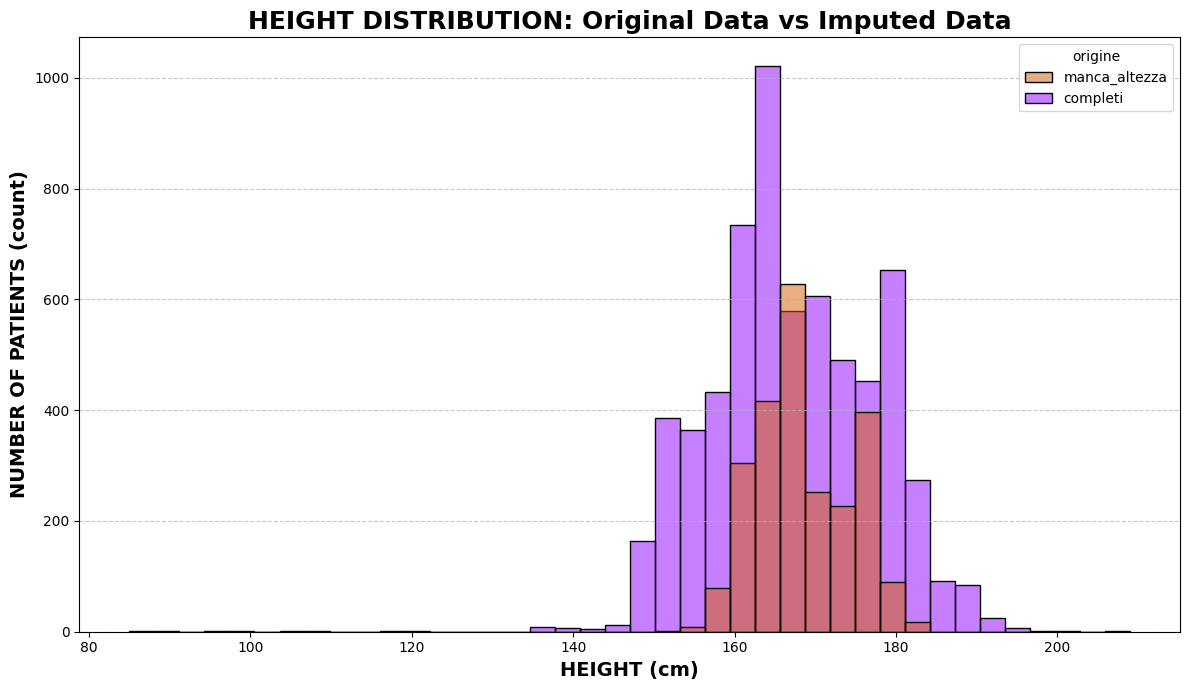

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Caricamento Dati ---
file_name = 'db_missforest.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit() # Esce dallo script se il file non c'è
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit() # Esce per qualsiasi altro errore di caricamento

# --- 2. Preparazione per il Grafico ---

# !!! NOTA IMPORTANTE !!!

categoria_originali = 'completi'    # O 'both'
categoria_imputati = 'manca_altezza' # O 'only_height'

# Filtriamo il DataFrame per includere SOLO i due gruppi che ci interessano
valori_da_visualizzare = [categoria_originali, categoria_imputati]
df_plot = df[df['origine'].isin(valori_da_visualizzare)]

# Controllo di sicurezza: verifica se abbiamo trovato dati
if df_plot.empty:
    print(f"\nATTENZIONE: Nessun dato trovato per i valori '{categoria_originali}' o '{categoria_imputati}'.")
    print("Controlla i nomi delle categorie nel tuo file CSV e aggiorna le variabili 'categoria_originali' e 'categoria_imputati'.")
    print("\nValori unici trovati nella colonna 'origin' del tuo file:")
    print(df['origine'].unique())
else:
    print(f"Dati filtrati pronti per il plot. Categorie trovate: {valori_da_visualizzare}")

    # --- 3. Creazione Grafico ---
    print("Visualizzazione grafico...")
    
    # Imposta la dimensione del grafico (larghezza, altezza in pollici)
    plt.figure(figsize=(12, 7))

    color_palette = {
        categoria_originali: '#8f00ff',  # viola
        categoria_imputati: '#D55E00',   # Un rosso/arancione
    }

    # Creiamo l'istogramma sovrapposto
    # 'data' = il nostro dataframe filtrato
    # 'x' = la colonna sull'asse x
    # 'hue' = la colonna da usare per colorare e separare i gruppi
    # 'kde=True' = aggiunge una linea di stima della densità (molto utile per il confronto)
    # 'alpha=0.5' = rende le barre semi-trasparenti per vedere la sovrapposizione
    # 'bins=40' = Aumenta il numero di barre per un maggior dettaglio
    sns.histplot(data=df_plot, 
                 x='height', 
                 hue='origine', 
                 #kde=True,
                 alpha=0.5,
                 element='bars', # Usa barre (default)
                 bins=40,
                 palette = color_palette) 

    # --- 4. Personalizzazione ---
    plt.title("HEIGHT DISTRIBUTION: Original Data vs Imputed Data", fontsize=18, weight='bold')
    plt.xlabel("HEIGHT (cm)", fontsize=14, weight='bold')
    plt.ylabel("NUMBER OF PATIENTS (count)", fontsize=14, weight='bold')
    #plt.legend(title='Origine Dati') # Aggiunge la legenda
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Aggiunge una griglia leggera

    # --- 5. Mostra Grafico ---
    plt.tight_layout() # Ottimizza lo spazio per evitare sovrapposizioni di etichette
    plt.show()

File 'db_missforest.csv' caricato con successo.
Dati filtrati pronti per il plot. Categorie trovate: ['completi', 'manca_altezza', 'manca_entrambi']
Visualizzazione grafico...


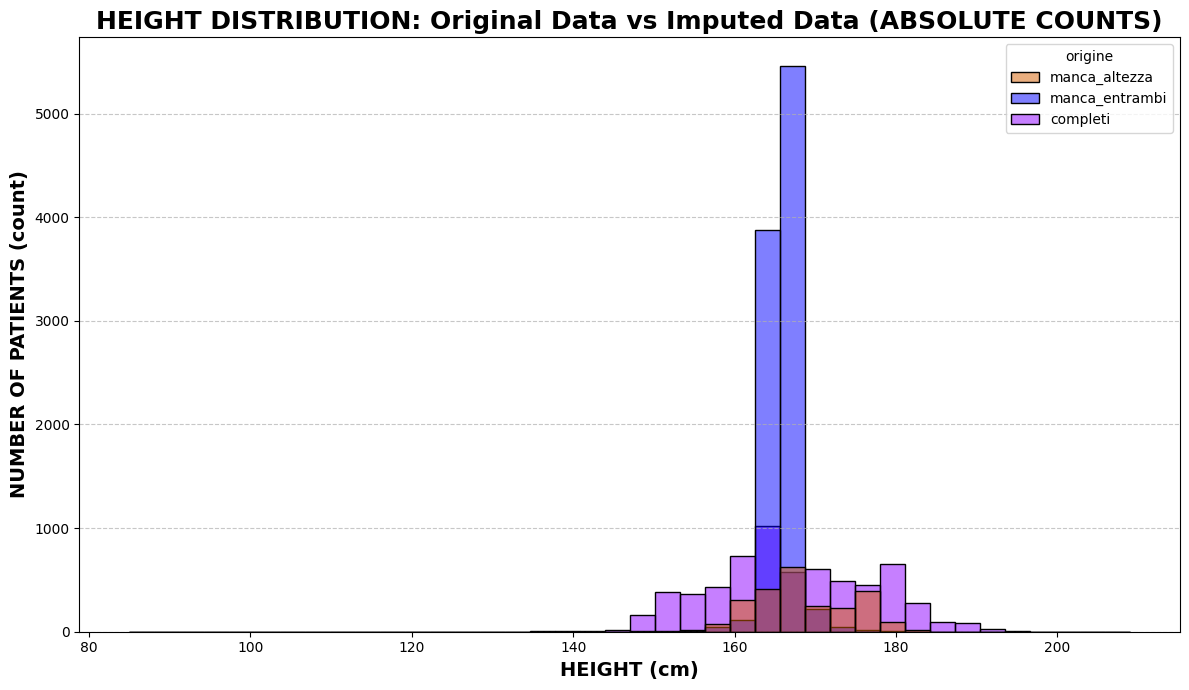

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Caricamento Dati ---
file_name = 'db_missforest.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit() # Esce dallo script se il file non c'è
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit() # Esce per qualsiasi altro errore di caricamento

# --- 2. Preparazione per il Grafico ---

# !!! NOTA IMPORTANTE !!!

categoria_originali = 'completi'    # O 'both'
categoria_imputati = 'manca_altezza' # O 'only_height'
categoria_imputati_entrambi = 'manca_entrambi'

# Filtriamo il DataFrame per includere SOLO i due gruppi che ci interessano
valori_da_visualizzare = [categoria_originali, categoria_imputati, categoria_imputati_entrambi]
df_plot = df[df['origine'].isin(valori_da_visualizzare)]

# Controllo di sicurezza: verifica se abbiamo trovato dati
if df_plot.empty:
    print(f"\nATTENZIONE: Nessun dato trovato per i valori '{categoria_originali}' o '{categoria_imputati}'.")
    print("Controlla i nomi delle categorie nel tuo file CSV e aggiorna le variabili 'categoria_originali' e 'categoria_imputati'.")
    print("\nValori unici trovati nella colonna 'origin' del tuo file:")
    print(df['origine'].unique())
else:
    print(f"Dati filtrati pronti per il plot. Categorie trovate: {valori_da_visualizzare}")

    # --- 3. Creazione Grafico ---
    print("Visualizzazione grafico...")
    
    # Imposta la dimensione del grafico (larghezza, altezza in pollici)
    plt.figure(figsize=(12, 7))

    color_palette = {
        categoria_originali: '#8f00ff',  # viola
        categoria_imputati: '#D55E00',   # Un rosso/arancione
        categoria_imputati_entrambi: '#0000FF' # blu
    }

    # Creiamo l'istogramma sovrapposto
    # 'data' = il nostro dataframe filtrato
    # 'x' = la colonna sull'asse x
    # 'hue' = la colonna da usare per colorare e separare i gruppi
    # 'kde=True' = aggiunge una linea di stima della densità (molto utile per il confronto)
    # 'alpha=0.5' = rende le barre semi-trasparenti per vedere la sovrapposizione
    # 'bins=40' = Aumenta il numero di barre per un maggior dettaglio
    sns.histplot(data=df_plot, 
                 x='height', 
                 hue='origine', 
                 #kde=True,
                 alpha=0.5,
                 element='bars', # Usa barre (default)
                 bins=40,
                 palette = color_palette) 

    # --- 4. Personalizzazione ---
    plt.title("HEIGHT DISTRIBUTION: Original Data vs Imputed Data (ABSOLUTE COUNTS)", fontsize=18, weight='bold')
    plt.xlabel("HEIGHT (cm)", fontsize=14, weight='bold')
    plt.ylabel("NUMBER OF PATIENTS (count)", fontsize=14, weight='bold')
    #plt.legend(title='Origine Dati') # Aggiunge la legenda
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Aggiunge una griglia leggera

    # --- 5. Mostra Grafico ---
    plt.tight_layout() # Ottimizza lo spazio per evitare sovrapposizioni di etichette
    plt.show()

Questo è utile se vuoi mostrare quanto sono numerosi i diversi gruppi, ma non permette di confrontare bene la forma delle distribuzioni, perché i gruppi hanno dimensioni molto diverse (ad esempio, il gruppo blu ha molti più dati, quindi domina il grafico).

Se vuoi confrontare la forma della distribuzione dell’altezza nei vari gruppi (indipendentemente dal numero di pazienti), allora devi normalizzare.

File 'db_missforest.csv' caricato con successo.
Dati filtrati pronti per il plot. Categorie trovate: ['completi', 'manca_altezza', 'manca_entrambi']


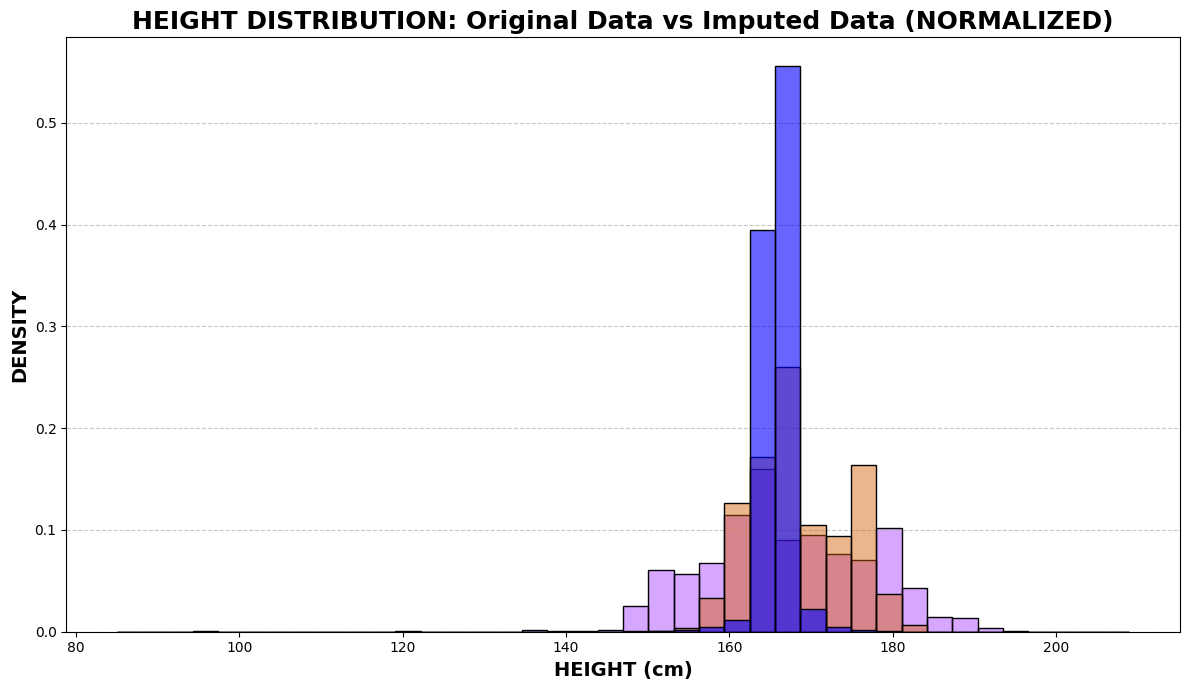

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Caricamento Dati ---
file_name = 'db_missforest.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit()
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit()

# --- 2. Preparazione per il Grafico ---
categoria_originali = 'completi'
categoria_imputati = 'manca_altezza'
categoria_imputati_entrambi = 'manca_entrambi'

valori_da_visualizzare = [categoria_originali, categoria_imputati, categoria_imputati_entrambi]
df_plot = df[df['origine'].isin(valori_da_visualizzare)]

if df_plot.empty:
    print(f"\nATTENZIONE: Nessun dato trovato per {valori_da_visualizzare}.")
    print("Controlla i nomi delle categorie nel CSV.")
    print("Valori unici trovati nella colonna 'origine':")
    print(df['origine'].unique())
    exit()
else:
    print(f"Dati filtrati pronti per il plot. Categorie trovate: {valori_da_visualizzare}")

# --- 3. Impostazioni per la normalizzazione ---
NORMALIZZA = True  # Cambia a False per tornare ai conteggi assoluti

if NORMALIZZA:
    stat_value = 'probability'   # o 'density'
    ylabel = "DENSITY"
else:
    stat_value = 'count'
    ylabel = "COUNT"

# --- 4. Calcolo bin comuni ---
# Calcoliamo i limiti dei bin sull'intero insieme
min_height = df_plot['height'].min()
max_height = df_plot['height'].max()
num_bins = 40
bin_edges = np.linspace(min_height, max_height, num_bins + 1)

# --- 5. Creazione Grafico ---
plt.figure(figsize=(12, 7))
color_palette = {
    categoria_originali: '#8f00ff',   # viola
    categoria_imputati: '#D55E00',    # arancio
    categoria_imputati_entrambi: '#0000FF'  # blu
}

# Disegniamo in ordine: prima dietro, poi davanti
sns.histplot(
    data=df_plot[df_plot['origine'] == categoria_originali],
    x='height',
    stat=stat_value,
    bins=bin_edges,               # <-- bin comuni
    common_norm=False,
    color=color_palette[categoria_originali],
    alpha=0.35,
    label='completi',
    zorder=1
)

sns.histplot(
    data=df_plot[df_plot['origine'] == categoria_imputati],
    x='height',
    stat=stat_value,
    bins=bin_edges,               # <-- bin comuni
    common_norm=False,
    color=color_palette[categoria_imputati],
    alpha=0.45,
    label='manca_altezza',
    zorder=2
)

sns.histplot(
    data=df_plot[df_plot['origine'] == categoria_imputati_entrambi],
    x='height',
    stat=stat_value,
    bins=bin_edges,               # <-- bin comuni
    common_norm=False,
    color=color_palette[categoria_imputati_entrambi],
    alpha=0.6,
    label='manca_entrambi',
    zorder=3
)

# --- 6. Personalizzazione ---
plt.title("HEIGHT DISTRIBUTION: Original Data vs Imputed Data (NORMALIZED)", fontsize=18, weight='bold')
plt.xlabel("HEIGHT (cm)", fontsize=14, weight='bold')
plt.ylabel("DENSITY", fontsize=14, weight='bold')
#plt.legend(title='Origine dei dati')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


- stat='density' calcola le altezze delle barre in modo che l’area totale dell’istogramma per ciascun gruppo sia pari a 1.

- stat = 'probability' la somma delle altezze di tutte le barre = 1 (ma non l’area).

- confronto dopo l'imputazione (peso)

File 'db_missforest.csv' caricato con successo.
Dati filtrati pronti per il plot. Categorie trovate: ['completi', 'manca_peso']
Visualizzazione grafico...


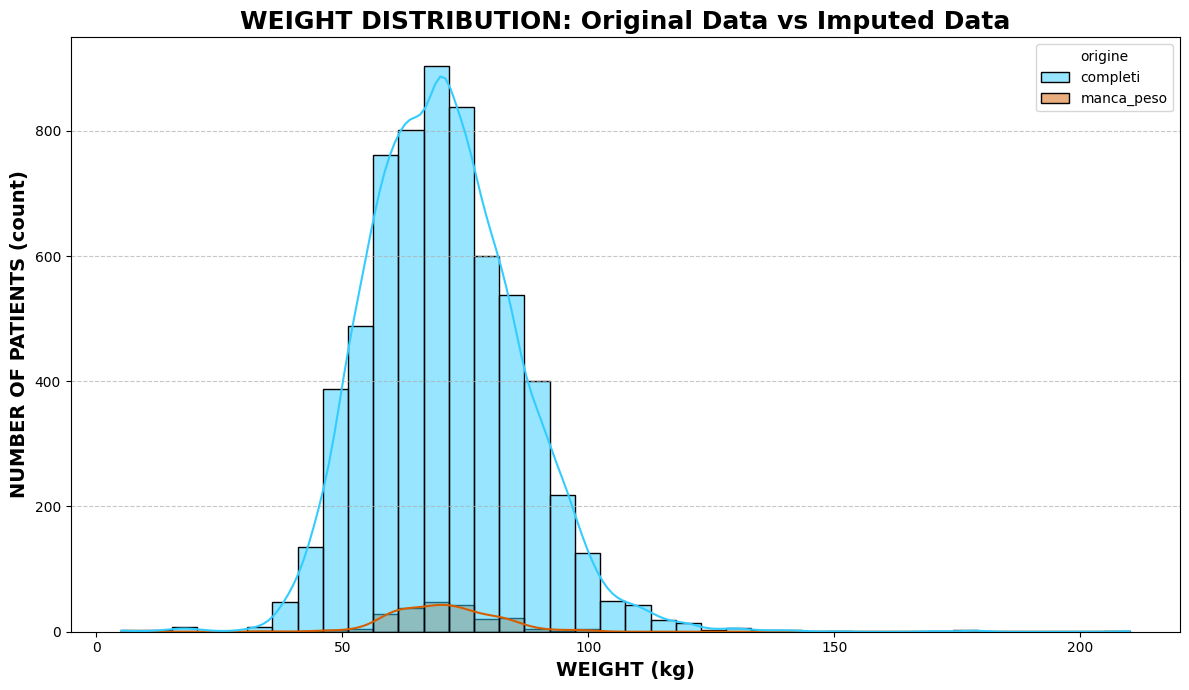

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Caricamento Dati ---
file_name = 'db_missforest.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit() # Esce dallo script se il file non c'è
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit() # Esce per qualsiasi altro errore di caricamento

# --- 2. Preparazione per il Grafico ---

# !!! NOTA IMPORTANTE !!!
# Assicurati che questi nomi corrispondano ESATTAMENTE a quelli nel tuo CSV.
categoria_originali = 'completi'    # O 'both'
categoria_imputati = 'manca_peso'   # O 'only_weight' <-- MODIFICATO

# Filtriamo il DataFrame per includere SOLO i due gruppi che ci interessano
valori_da_visualizzare = [categoria_originali, categoria_imputati]
# Assicurati che la colonna si chiami 'origine' (come nel tuo esempio) o 'origin'
df_plot = df[df['origine'].isin(valori_da_visualizzare)] 

# Controllo di sicurezza: verifica se abbiamo trovato dati
if df_plot.empty:
    print(f"\nATTENZIONE: Nessun dato trovato per i valori '{categoria_originali}' o '{categoria_imputati}'.")
    print("Controlla i nomi delle categorie nel tuo file CSV e aggiorna le variabili.")
    print("\nValori unici trovati nella colonna 'origine' del tuo file:")
    print(df['origine'].unique())
else:
    print(f"Dati filtrati pronti per il plot. Categorie trovate: {valori_da_visualizzare}")

    # --- 3. Creazione Grafico ---
    print("Visualizzazione grafico...")
    
    # Imposta la dimensione del grafico (larghezza, altezza in pollici)
    plt.figure(figsize=(12, 7))

    # --- Palette Colori ---
    color_palette = {
        categoria_originali: '#33ccff',  # <-- Colore richiesto
        categoria_imputati: '#D55E00'   # Un rosso/arancione contrastante
    }

    # Creiamo l'istogramma sovrapposto
    sns.histplot(data=df_plot, 
                 x='weight',           # <-- MODIFICATO
                 hue='origine', 
                 kde=True,
                 alpha=0.5,
                 element='bars', 
                 bins=40,
                 palette=color_palette) # <-- Usa la nuova palette


    # --- 4. Personalizzazione ---
    plt.title("WEIGHT DISTRIBUTION: Original Data vs Imputed Data", fontsize=18, weight='bold')
    plt.xlabel("WEIGHT (kg)", fontsize=14, weight='bold')
    plt.ylabel("NUMBER OF PATIENTS (count)", fontsize=14, weight='bold')
    #plt.legend(title='Origine Dati') 
    plt.grid(axis='y', linestyle='--', alpha=0.7) 

    # --- 5. Mostra Grafico ---
    plt.tight_layout() 
    plt.show()

File 'db_missforest.csv' caricato con successo.
Dati filtrati pronti per il plot. Categorie trovate: ['completi', 'manca_entrambi', 'manca_peso']
Visualizzazione grafico...


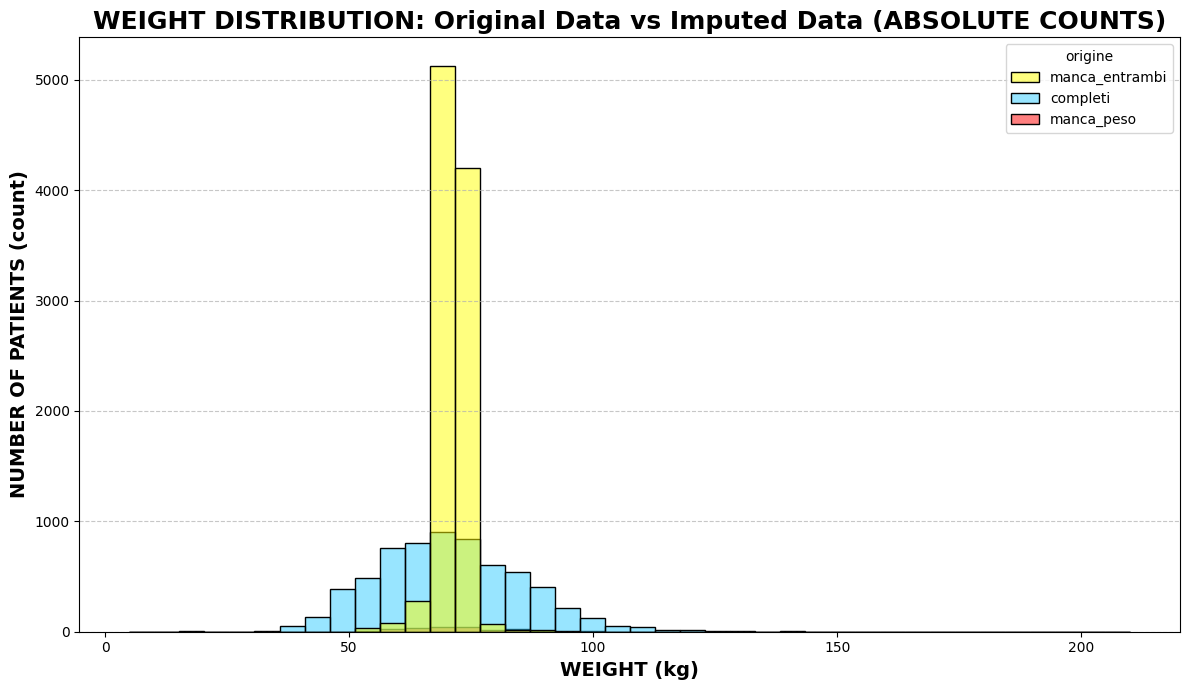

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Caricamento Dati ---
file_name = 'db_missforest.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit() # Esce dallo script se il file non c'è
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit() # Esce per qualsiasi altro errore di caricamento

# --- 2. Preparazione per il Grafico ---

# !!! NOTA IMPORTANTE !!!
# Assicurati che questi nomi corrispondano ESATTAMENTE a quelli nel tuo CSV.
categoria_originali = 'completi'    # O 'both'
categoria_imputati = 'manca_peso'   # O 'only_weight' <-- MODIFICATO
categoria_imputati_entrambi = 'manca_entrambi'

# Filtriamo il DataFrame per includere SOLO i due gruppi che ci interessano
valori_da_visualizzare = [categoria_originali, categoria_imputati_entrambi, categoria_imputati]
# Assicurati che la colonna si chiami 'origine' (come nel tuo esempio) o 'origin'
df_plot = df[df['origine'].isin(valori_da_visualizzare)] 

# Controllo di sicurezza: verifica se abbiamo trovato dati
if df_plot.empty:
    print(f"\nATTENZIONE: Nessun dato trovato per i valori '{categoria_originali}' o '{categoria_imputati}'.")
    print("Controlla i nomi delle categorie nel tuo file CSV e aggiorna le variabili.")
    print("\nValori unici trovati nella colonna 'origine' del tuo file:")
    print(df['origine'].unique())
else:
    print(f"Dati filtrati pronti per il plot. Categorie trovate: {valori_da_visualizzare}")

    # --- 3. Creazione Grafico ---
    print("Visualizzazione grafico...")
    
    # Imposta la dimensione del grafico (larghezza, altezza in pollici)
    plt.figure(figsize=(12, 7))

    # --- Palette Colori ---
    color_palette = {
        categoria_imputati: '#FF0000',   # rosso
        categoria_originali: '#33ccff',  # azzurrino
        categoria_imputati_entrambi: '#FFFF00' # giallo

    }

    # Creiamo l'istogramma sovrapposto
    sns.histplot(data=df_plot, 
                 x='weight',           # <-- MODIFICATO
                 hue='origine', 
                 #kde=True,
                 alpha=0.5,
                 element='bars', 
                 bins=40,
                 palette=color_palette) # <-- Usa la nuova palette


    # --- 4. Personalizzazione ---
    plt.title("WEIGHT DISTRIBUTION: Original Data vs Imputed Data (ABSOLUTE COUNTS)", fontsize=18, weight='bold')
    plt.xlabel("WEIGHT (kg)", fontsize=14, weight='bold')
    plt.ylabel("NUMBER OF PATIENTS (count)", fontsize=14, weight='bold')
    #plt.legend(title='Origine Dati') 
    plt.grid(axis='y', linestyle='--', alpha=0.7) 

    # --- 5. Mostra Grafico ---
    plt.tight_layout() 
    plt.show()

File 'db_missforest.csv' caricato con successo.
Visualizzazione grafico...


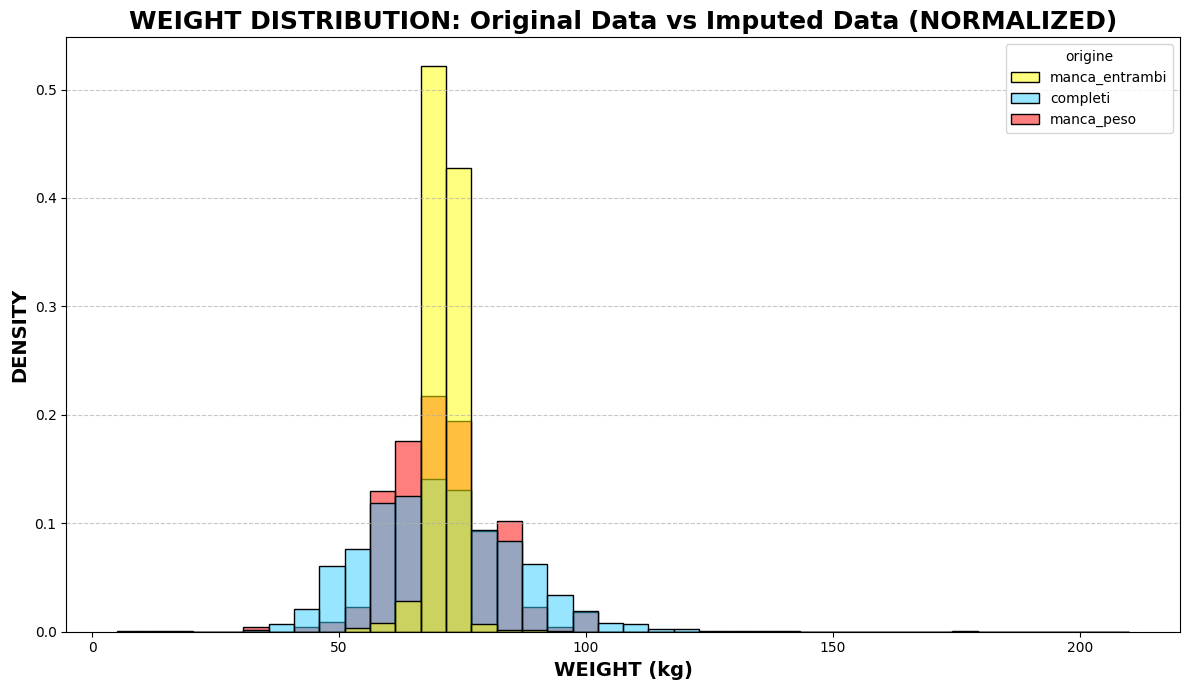

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Caricamento Dati ---
file_name = 'db_missforest.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit() # Esce dallo script se il file non c'è
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit() # Esce per qualsiasi altro errore di caricamento

# --- 2. Preparazione per il Grafico ---

# !!! NOTA IMPORTANTE !!!
# Assicurati che questi nomi corrispondano ESATTAMENTE a quelli nel tuo CSV.
categoria_originali = 'completi'    # O 'both'
categoria_imputati = 'manca_peso'   # O 'only_weight' <-- MODIFICATO
categoria_imputati_entrambi = 'manca_entrambi'

# Filtriamo il DataFrame per includere SOLO i due gruppi che ci interessano
valori_da_visualizzare = [categoria_originali, categoria_imputati_entrambi, categoria_imputati]
# Assicurati che la colonna si chiami 'origine' (come nel tuo esempio) o 'origin'
df_plot = df[df['origine'].isin(valori_da_visualizzare)] 

    
# --- 3. Impostazioni per la normalizzazione ---
NORMALIZZA = True  # Cambia a False per tornare ai conteggi assoluti

if NORMALIZZA:
    stat_value = 'probability'      # oppure 'probability' se preferisci percentuali
else:
    stat_value = 'count'

# --- 4. Creazione Grafico ---
print("Visualizzazione grafico...")

# Imposta la dimensione del grafico (larghezza, altezza in pollici)
plt.figure(figsize=(12, 7))

# --- Palette Colori ---
color_palette = {
    categoria_imputati: '#FF0000',   # rosso
    categoria_originali: '#33ccff',  # azzurrino
    categoria_imputati_entrambi: '#FFFF00' # giallo

}

# Creiamo l'istogramma sovrapposto
sns.histplot(data=df_plot, 
                x='weight',           
                hue='origine', 
                #kde=True,
                stat=stat_value,          # <-- normalizzazione controllata qui
                common_norm=False,        # ogni gruppo ha la propria normalizzazione
                alpha=0.5,
                element='bars', 
                bins=40,
                palette=color_palette) # <-- Usa la nuova palette


# --- 4. Personalizzazione ---
plt.title("WEIGHT DISTRIBUTION: Original Data vs Imputed Data (NORMALIZED)", fontsize=18, weight='bold')
plt.xlabel("WEIGHT (kg)", fontsize=14, weight='bold')
plt.ylabel("DENSITY", fontsize=14, weight='bold')
#plt.legend(title='Origine Dati') 
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# --- 5. Mostra Grafico ---
plt.tight_layout() 
plt.show()

- quantità di maschi/femmine che hanno dichiarato peso e altezza e che non hanno dichiarato peso o altezza o entrambi.

File 'db_missforest.csv' caricato con successo.
--- Conteggi Sesso per Origine ---
sex_label       Femmine (1)  Maschi (0)
origine                                
completi               3468        2943
manca_altezza          1296        1123
manca_entrambi         4356        5467
manca_peso              109         107
---------------------------------
Creazione grafici in corso...


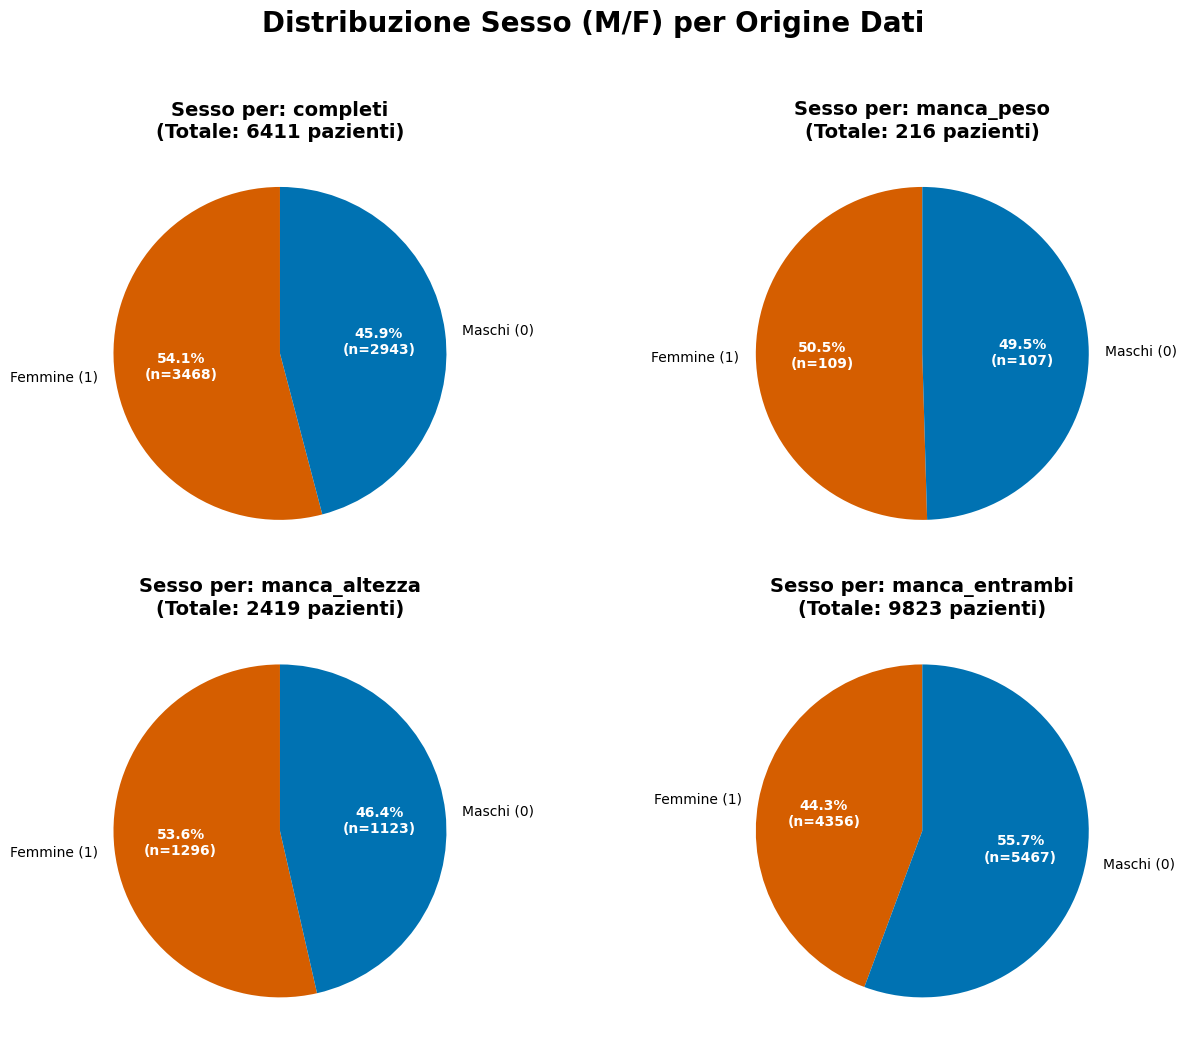

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Caricamento Dati ---
file_name = 'db_missforest.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit()
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit()

# --- 2. Preparazione Dati ---

# !!! ATTENZIONE: Controlla il nome della colonna 'origine'
# Negli script precedenti a volte era 'origin' e a volte 'origine'
# Modifica la riga qui sotto se il nome è diverso.
colonna_origine = 'origine' 
colonna_sesso = 'sex'

# Controlliamo se le colonne esistono
if colonna_origine not in df.columns or colonna_sesso not in df.columns:
    print(f"ERRORE: La colonna '{colonna_origine}' o '{colonna_sesso}' non è stata trovata.")
    print(f"Colonne disponibili nel file: {df.columns.tolist()}")
    exit()

# Mappiamo i valori numerici del sesso (0, 1) a etichette più chiare
# Questo renderà i grafici a torta leggibili
df['sex_label'] = df[colonna_sesso].map({0: 'Maschi (0)', 1: 'Femmine (1)'})

# Calcoliamo i conteggi: riga per 'origine', colonna per 'sex_label'
try:
    data_counts = pd.crosstab(df[colonna_origine], df['sex_label'])
except KeyError:
     print("ERRORE: Categorie non trovate. Controlla i nomi delle colonne nel CSV.")
     exit()

print("--- Conteggi Sesso per Origine ---")
print(data_counts)
print("---------------------------------")


# --- 3. Creazione Grafici ---

# Definiamo le 4 categorie che vogliamo plottare
# ATTENZIONE: Assicurati che questi nomi corrispondano ESATTAMENTE al tuo CSV
categories = ['completi', 'manca_peso', 'manca_altezza', 'manca_entrambi']

# Definiamo i colori (per coerenza: blu per maschi, rosa/rosso per femmine)
# Usiamo un dizionario per mappare l'etichetta al colore corretto
color_map = {
    'Maschi (0)': '#0072B2',  # Blu
    'Femmine (1)': '#D55E00'   # Rosso/Arancione
}

# Creiamo una griglia 2x2 per i nostri 4 grafici
fig, axes = plt.subplots(2, 2, figsize=(13, 11))

# Appiattiamo l'array 'axes' (da 2x2 a 1x4) per un loop più semplice
# L'ordine sarà: [in alto a sx], [in alto a dx], [in basso a sx], [in basso a dx]
ax_list = axes.flatten() 

print("Creazione grafici in corso...")

# Iteriamo su ogni categoria e sull'asse corrispondente
for i, category in enumerate(categories):
    ax = ax_list[i] # Seleziona l'asse (grafico) corrente
    
    # Controlliamo se la categoria esiste nei nostri dati
    if category in data_counts.index:
        # Estraiamo i dati per questa torta (es. Maschi: 500, Femmine: 450)
        pie_data = data_counts.loc[category]
        
        # Rimuoviamo eventuali categorie con 0 pazienti (che darebbero errore)
        pie_data = pie_data[pie_data > 0]
        
        # Calcoliamo il totale per questa categoria
        total = pie_data.sum()
        
        # Ordiniamo i colori in base alle etichette presenti
        pie_colors = [color_map[label] for label in pie_data.index]

        # Creiamo il grafico a torta
        wedges, texts, autotexts = ax.pie(
            pie_data,
            labels=pie_data.index,    # Etichette (Maschi, Femmine)
            colors=pie_colors,        # Colori definiti
            # 'autopct' formatta il testo: mostra % e il conteggio (n=...)
            autopct=lambda p: f'{p:.1f}%\n(n={p*total/100.0:.0f})',
            startangle=90,            # Inizia la prima fetta a ore 12
            textprops={'fontsize': 10} # Stile testo etichette
        )
        
        # Miglioriamo la leggibilità dei testi percentuali (spesso bianchi)
        plt.setp(autotexts, size=10, weight="bold", color="white")

        ax.set_title(f'Sesso per: {category}\n(Totale: {total} pazienti)', 
                     fontsize=14, weight='bold')
    
    else:
        # Se la categoria non esiste (es. 'manca_entrambi' non ha dati)
        ax.set_title(f'Sesso per: {category}\n(DATI NON TROVATI)', 
                     fontsize=14, weight='bold', color='red')
        ax.text(0.5, 0.5, 'N/A', horizontalalignment='center', 
                verticalalignment='center', fontsize=20, color='grey')
        ax.set_axis_off() # Nascondi gli assi

# Aggiungiamo un titolo generale a tutta la figura
fig.suptitle('Distribuzione Sesso (M/F) per Origine Dati', fontsize=20, weight='bold')

# Ottimizziamo il layout per evitare sovrapposizioni
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

# --- 4. Mostra Grafico ---
plt.show()

In [1]:
pip install pywaffle matplotlib fontawesome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 62.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


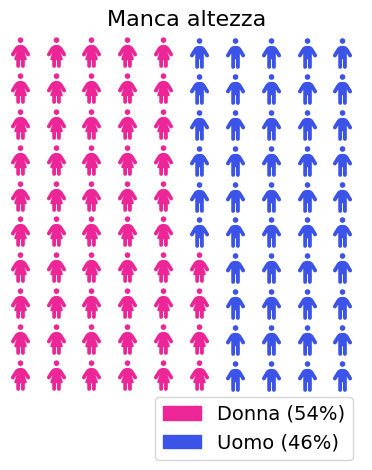

In [40]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

# Dati di esempio (72% e 28%)
# Nota: La somma dei valori dovrebbe idealmente essere 100 per una griglia 10x10
data = {
    'Donna': 54,
    'Uomo': 46
}

# Colori da usare per le categorie
colors = ["#ed2697", "#3c53e8"] # Rosa e Blu

# Icone di Font Awesome per rappresentare le categorie
# 'female' e 'male' sono icone comuni di Font Awesome
icons = ['female', 'male']

# Creazione del grafico Waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,                      # 10 righe
    columns=10,                   # 10 colonne (totale 100 "unità")
    values=data,
    colors=colors,
    icons=icons,                  # Usa le icone specificate
    font_size=22,                 # Dimensione delle icone
    icon_style='solid',           # Stile delle icone (solido)
    icon_legend=False,            # Non mostrare la legenda con icone
    
    # Impostazioni della Legenda (per mostrare i nomi delle categorie e le percentuali)
    legend={
        'labels': [f"Donna ({data['Donna']}%)", f"Uomo ({data['Uomo']}%)"],
        #'loc': 'lower right',
        'bbox_to_anchor': (1, 0),
        'ncol': 1,
        'fontsize': 14
    },
    
    # Titolo del grafico (opzionale)
    title={'label': 'Manca altezza', 'fontsize': 16}
)

# Rimuovi l'asse per un aspetto più pulito
fig.gca().set_axis_off()

# Mostra il grafico
plt.show()

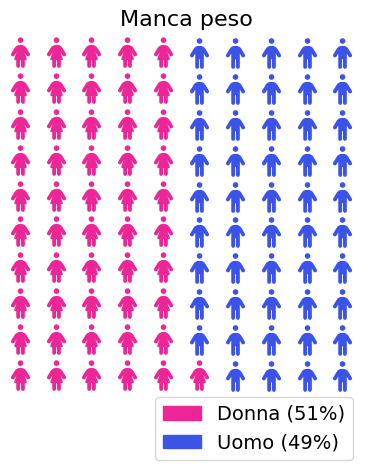

In [43]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

# Dati di esempio (72% e 28%)
# Nota: La somma dei valori dovrebbe idealmente essere 100 per una griglia 10x10
data = {
    'Donna': 51,
    'Uomo': 49
}

# Colori da usare per le categorie
colors = ["#ed2697", "#3c53e8"] # Rosa e Blu

# Icone di Font Awesome per rappresentare le categorie
# 'female' e 'male' sono icone comuni di Font Awesome
icons = ['female', 'male']

# Creazione del grafico Waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,                      # 10 righe
    columns=10,                   # 10 colonne (totale 100 "unità")
    values=data,
    colors=colors,
    icons=icons,                  # Usa le icone specificate
    font_size=22,                 # Dimensione delle icone
    icon_style='solid',           # Stile delle icone (solido)
    icon_legend=False,            # Non mostrare la legenda con icone
    
    # Impostazioni della Legenda (per mostrare i nomi delle categorie e le percentuali)
    legend={
        'labels': [f"Donna ({data['Donna']}%)", f"Uomo ({data['Uomo']}%)"],
        #'loc': 'lower right',
        'bbox_to_anchor': (1, 0),
        'ncol': 1,
        'fontsize': 14
    },
    
    # Titolo del grafico (opzionale)
    title={'label': 'Manca peso', 'fontsize': 16}
)

# Rimuovi l'asse per un aspetto più pulito
fig.gca().set_axis_off()

# Mostra il grafico
plt.show()

- fasce d'età che hanno dichiarato peso e altezza e che non hanno dichiarato peso o altezza o entrambi.

File 'db_missforest.csv' caricato con successo.
Creazione grafico in corso...


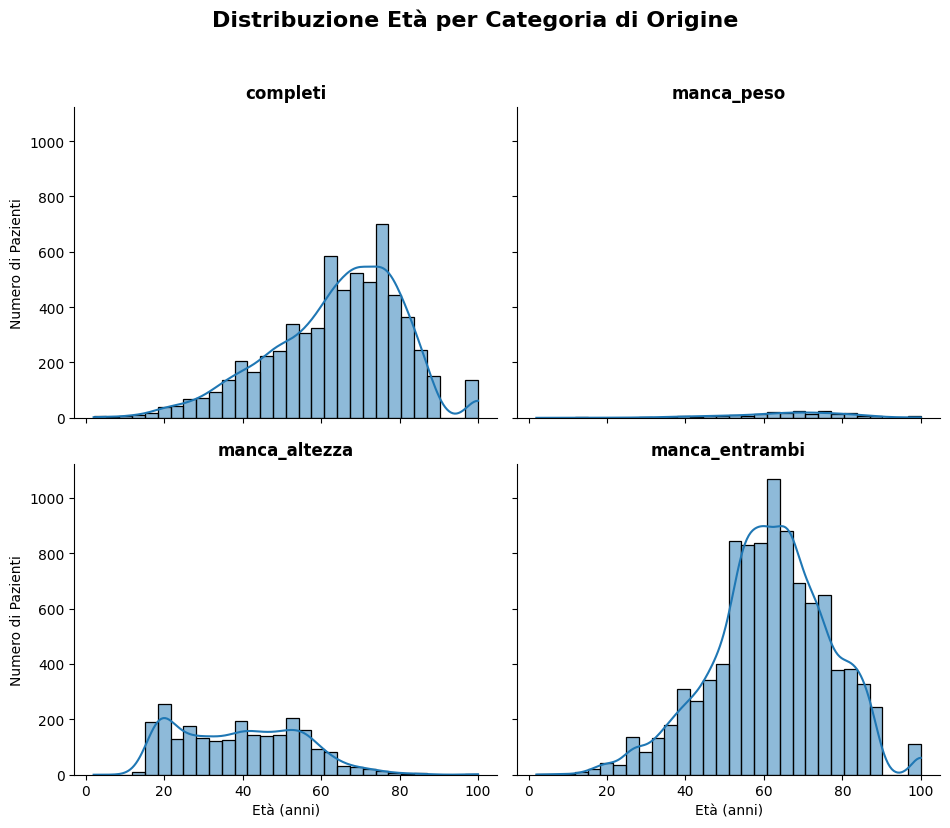

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Caricamento Dati ---
file_name = 'db_missforest.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit()
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit()

# --- 2. Preparazione Dati ---

# !!! ATTENZIONE: Controlla il nome della colonna 'origine'
colonna_origine = 'origine' 
colonna_eta = 'age'

# Controlliamo se le colonne esistono
if colonna_origine not in df.columns or colonna_eta not in df.columns:
    print(f"ERRORE: La colonna '{colonna_origine}' o '{colonna_eta}' non è stata trovata.")
    print(f"Colonne disponibili nel file: {df.columns.tolist()}")
    exit()

# Definiamo l'ordine desiderato per le categorie
categories_order = [
    'completi', 
    'manca_peso', 
    'manca_altezza', 
    'manca_entrambi'
]

# Controllo di sicurezza: verifica se le categorie nel file corrispondono
categorie_trovate = df[colonna_origine].unique()
for cat in categories_order:
    if cat not in categorie_trovate:
        print(f"ATTENZIONE: La categoria '{cat}' non è stata trovata nel file.")
        # Potresti voler rimuovere la categoria da categories_order se non esiste
        # categories_order.remove(cat)


# --- 3. Creazione Grafico a Griglia ---

print("Creazione grafico in corso...")

# Usiamo displot() per creare una griglia (FacetGrid)
# 'data' = il nostro dataframe
# 'x' = la colonna sull'asse x
# 'col' = la colonna da usare per creare i grafici separati (le nostre 4 casistiche)
# 'col_wrap=2' = organizza la griglia in 2 colonne (quindi 2x2)
# 'col_order' = forza l'ordine dei grafici
# 'kde=True' = aggiunge la linea di stima della densità
# 'height=4, aspect=1.2' = imposta la dimensione di CIASCUN grafico
g = sns.displot(
    data=df,
    x=colonna_eta,
    col=colonna_origine,
    col_wrap=2,               
    col_order=categories_order,
    kde=True,
    bins=30,                  # Un numero ragionevole di bin per l'età
    height=4,                 # Altezza di ogni singolo grafico
    aspect=1.2                # Rapporto larghezza/altezza
)


# --- 4. Personalizzazione Titoli ---

# Aggiungiamo un titolo generale sopra tutti i grafici
g.fig.suptitle('Distribuzione Età per Categoria di Origine', fontsize=16, weight='bold', y=1.03)

# Impostiamo le etichette per gli assi X e Y (lo farà per tutti i grafici)
g.set_axis_labels('Età (anni)', 'Numero di Pazienti')

# Modifichiamo i titoli dei singoli grafici (rimuovendo la parte "origine = ...")
g.set_titles("{col_name}", size=12, weight='bold')


# --- 5. Mostra Grafico ---
plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=247b8f4a-5d0c-407e-bcc1-03b5acbab0dd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>